# Kraken2 taxanomic annotation 

Kraken2 is a taxonomic classification system that uses short genomic substrings (k-mer) matches. The k-mer is matched within a query sequence with the lowest common ancestor of all genomes containing the exact k-mer. Kraken is fast and provides a taxa report for each sample. To read more about Kraken2 and install the tool visit github.com/DerrickWood/kraken2/wiki. 

This step is on Carbonate, a supercomputer, because the data set was too large to transfer to a Jetstream VM. It is possible to do this step on Jetstream, if a larger volume is requested and attached. This script will align reads against the kraken database to find the taxa. In this case, I am using sediment metagenome data sampled from hydrocarbon seepages in the Gulf of Mexico and identifying taxa families. Taxa identification is necessary to find species richness later for the rarefaction curve. Rarefaction curves are described later, after the taxa is identified and generated into a .csv table. 

** Installing kraken2 locally **

Documentation available here, 
- github.com/DerrickWood/kraken2/wiki
- https://blogs.iu.edu/ncgas/2019/09/24/taxa-annotation-for-shotgun-sequenced-metagenomic-data/

** Input data **

Metagenomic datasets. In this case the metagenomes were downloaded from NCBI's Sequence Read Archive (SRA) under the BioProject number PRJNA553005. There are seven sediment metagenomes under this BioProject.

** Running kraken2 command ** 

`kraken2 --db $KRAKEN_DB --use-names --report-zero-counts --paired "$f"_1.fq "$f"_2.fq --report "$f"_kraken_report`

Looking at the command above, the input samples are the forward and reverse read of the sample. Only one sample can be ran at a time using this command. In this case we had seven samples, so the command was run seven times. 

** Results from kraken2 **

This command will generate a report with the specified parameters (use-names, report-zero-counts, paired) for the sample as output. More information about Kraken2 parameters are described in the manual. The output, "$f"_kraken_report generates a table that looks like:

Sample Name | % of aligned reads | # of reads covered by clade | # of reads assigned to this taxa | rank code | NCBI Taxa ID
------------ | ------------- | ------------ | ------------- | ------------- | ------------- 
Content from cell 1 | Content from cell 2 | cell 3 | cell 4 | cell 5 | cell 6 
Content in the first column | Content in the second column | third | fourth | fifth | six 
Content in the first column | Content in the second column | third | fourth | fifth | six 
Content in the first column | Content in the second column | third | fourth | fifth | six 

Since every output is in a separate table, we need to combine them to make a rarefaction curve later. To prepare for this step, all kraken reports should be placed in thier own directory.

## Generating one output table for all the samples
Since the kraken reports currently are generated for each sample, we will need to generate one output csv or tsv table that has the taxanomic abundances for all the samples. The resulting table will be provides as input for the different visualization tools described in this notebook. 

** Download the python3 script from GitHub **

`git clone https://github.com/npbhavya/Kraken2-output-manipulation.git`

** Place all the kraken2 reports to one directory **

`mkdir kraken_report` 

`mv *_kraken_report FILEPATH/kraken_report/`

** Run the command **

`python kraken-multiple-taxa.py -d kraken_report/ -r F -c 2 -o kraken-report-final`

** Result explained **
The following command is used to get taxa information instead of taxa ID. The input -d for script the directory of kraken reports for each sample. 
-r defines taxonomic rank: (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies
-c defines the column to be included in the final report col1: number of reads covered; col2: percentage of reads covered by taxa
-o output, defines output file name

The output is a table of taxa families followed by numbers that will look something like:

        Taxa    ['sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7']
        Pseudomonadaceae        ['78249', '103170', '81428', '76970', '75855', '69162', '92573']
        Moraxellaceae   ['9420', '6299', '10383', '10311', '6685', '3269', '9622']
        Enterobacteriaceae      ['31660', '27116', '34082', '31873', '24965', '16778', '33615']

This step was run again using a different rank (Phylum) and using percentages for the alluvial plot. kraken_reports_phylum.csv

** Converting the table to csv **

`sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_final_table.csv`

The output for the csv file command should look like a table. This table is now ready to be imported to use in R scripts below. 

# Jupyter notebook

The below steps onwards the scripts and commands can be run on Jupyter notebooks. 

** Jetstream **

Jetstream is a cloud computing resource that provides access to pre-configured virtual machines (VM) with root access. Using VM’s helps with the transition of non-computer science background professionals to the command line, software installs and onto running analysis on LINUX environment (as most HPC clusters).  For more on Jetstream, go https://kb.iu.edu/d/bfde.

** Setting up Jupyter notebook on Jetstream instance ** 

A medium Ubuntu 18.04 instance was launched and Jupyter notebooks was installed following https://blogs.iu.edu/ncgas/2020/06/15/installing-jupyter-notebook-on-jetstream/. Select a instance size depending on your dataset. In additon, a 100 GB volume was attached. Request a larger volume if needed. The final kraken report in .csv format was transferred to the volume. 

** Input files ** 

Generated " ** *kraken_report_final_table.csv* **" table

## Rarefraction curve 

** Introduction **

A rarefaction curve shows species richness of a sample to determine if a sample is representative of a larger population by plotting the sample size and species. A rarefaction curve showing a respresentative sample will grow rapidly and then slowly plateau. The rapid growth shows how every read in the sample identifies as a new organism and the plateau shows the rare species in the sample that remain to be sampled. If your samples do not reach a plateau, it is suggested that most species in the sample are rare; Increasing the sample size will create a better respresentation of the larger population.   
In regard to our data, we are making a rarefaction curve to determine if the sediment metagenome samples are respresentative of the larger population in the Gulf of Mexico.

Before plotting a rarefaction curve, it is necessary to identify taxa using Kraken2 or another taxa identification tool because this information is neccessary to calculate species richness. The .csv table generated from the kraken reports will be used. The input for the table will be read as a table, but then transposed and read as a data frame for the rarefaction curve.

** Below is the code to plot the rarefaction curves for the metagenomic datasets from the " kraken_report_final_table.csv " table **

In [1]:
#Installation of the packages if they aren't already downloaded
install.packages("vegan");

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’




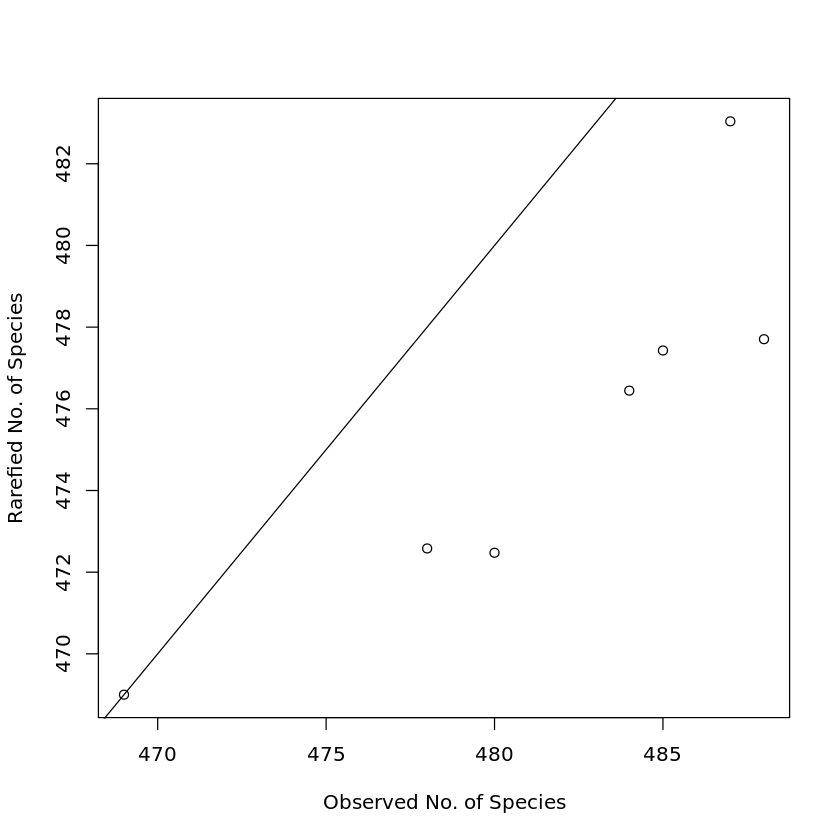

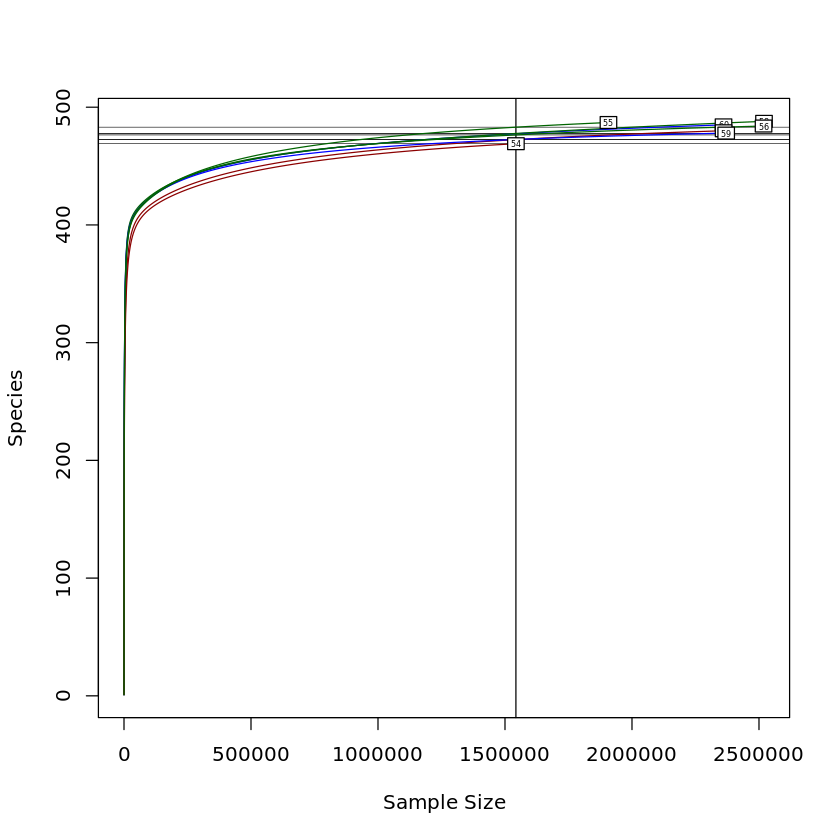

In [27]:
library(vegan);

#importing the file and parsing the file correctly
#Replace the kraken.csv name to the actual filename.
Data=read.table("kraken_report_final_taxa_table.csv", sep=",", row.names = 1, header=TRUE);

#replacing long file names with shorter ones
colnames(Data)[1:7] = c("60","57","58","59","55","54","56")

Data_t=as.data.frame(t(Data));

#count the number of species
S = specnumber(Data_t);
raremax = min(rowSums(Data_t));
#print(raremax);

#Rarefaction of the samples
Srare = rarefy(Data_t, raremax);
#print(Srare);

#plotting the rarefaction curves
plot(S, Srare, xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")
abline(0, 1)
rarecurve(Data_t, step =20, sample = raremax, 
          col = c("blue", "darkred", "darkgreen", "blue", "darkgreen", "darkred", "darkgreen"), 
          cex = 0.4, )

** Graph explained **

Looking at the rarefaction curve calculated using the metagenome samples from the Gulf of Mexico above, the curve grows rapidly and then plateaus. The plateau in the graph shows that no new species are being identified in the samples. This graph shows that the seven samples taken is a representative sample of the larger population of microbes in the Gulf of Mexico. A non-representative sample would not reach a plateau, if this happens you may need to add more samples to your data set. 

## Ordination plots
## PCA plots

** Introduction ** 

A principal component analysis (PCA) is a type of ordination plot. Ordination plots summarize data by reducing the dimensions, or variables, and plotting the samples in a format that can be visualized. A PCA plot shows the direction of maximal variation between multiple variables by condensing them into new variables, called principal components, in a data set without compromising information. A PCA plot reduces the dimensions of a matrix to show how similar or dissimilar samples are based on their distance and grouping of each other. 

For more information on ordination plots, https://ncgas.org/training/r-for-biologists-workshop.html. 

** Installations ** 

In preparation to make an ordination plot using devtools, several dependency packages also must installed. On the version of R I am using (3.4.4), the libraries for these packages are not installed. This is because it is a older version of R. The step of installing dependecy libraries in the terminal with file path to the library is neccessary or devtools will not install properly and the script won't work.

_Requirements_
- R v3.4.4
- curl libraries 
- ssl libraries 
- xml2 libraries

Download the below libraries to the instance in case they are not already installed,

    sudo apt-get install -y libcurl4-openssl-dev
    sudo apt-get install libssl-dev
    sudo apt-get install libxml2-dev 

In [25]:
#Installation of the packages if they aren't already downloaded for plotting PCA 

install.packages("gh");
install.packages("usethis");
install.packages("covr");
install.packages("roxygen2");
install.packages("rversions");
install.packages("devtools");
library(devtools)
install_github("vqv/ggbiplot") 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




ggplot2      (NA -> 3.3.2) [CRAN]
plyr         (NA -> 1.8.6) [CRAN]
scales       (NA -> 1.1.1) [CRAN]
farver       (NA -> 2.0.3) [CRAN]
labeling     (NA -> 0.3  ) [CRAN]
munsell      (NA -> 0.5.0) [CRAN]
RColorBrewer (NA -> 1.1-2) [CRAN]
viridisLite  (NA -> 0.3.0) [CRAN]
colorspace   (NA -> 1.4-1) [CRAN]
gtable       (NA -> 0.3.0) [CRAN]
isoband      (NA -> 0.2.2) [CRAN]


Installing 11 packages: ggplot2, plyr, scales, farver, labeling, munsell, RColorBrewer, viridisLite, colorspace, gtable, isoband

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpE3a5f9/remotes60654a40244c/vqv-ggbiplot-7325e88/DESCRIPTION’
─  preparing ‘ggbiplot’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘ggbiplot_0.55.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



** Below is the code to plot the PCA plot for the metagenomic datasets from the " kraken_report_final_table.csv " table **

suggest seeing ggbiplot documentation to add labels and adjust size and placement ``varname.size = 3, varname.adjust = 1`` 

explain adding labels after because 

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     44636.843 6.420e+03 3.036e+03 1.550e+03 525.07724
Proportion of Variance     0.974 2.015e-02 4.510e-03 1.180e-03   0.00013
Cumulative Proportion      0.974 9.941e-01 9.987e-01 9.998e-01   0.99997
                             PC6       PC7
Standard deviation     244.57140 2.826e-12
Proportion of Variance   0.00003 0.000e+00
Cumulative Proportion    1.00000 1.000e+00

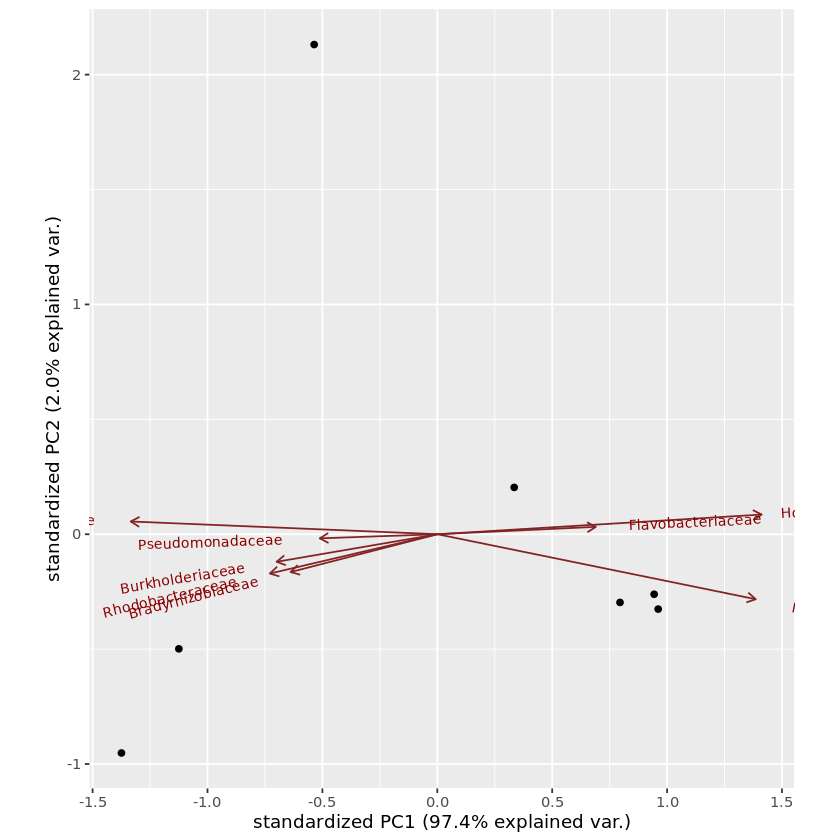

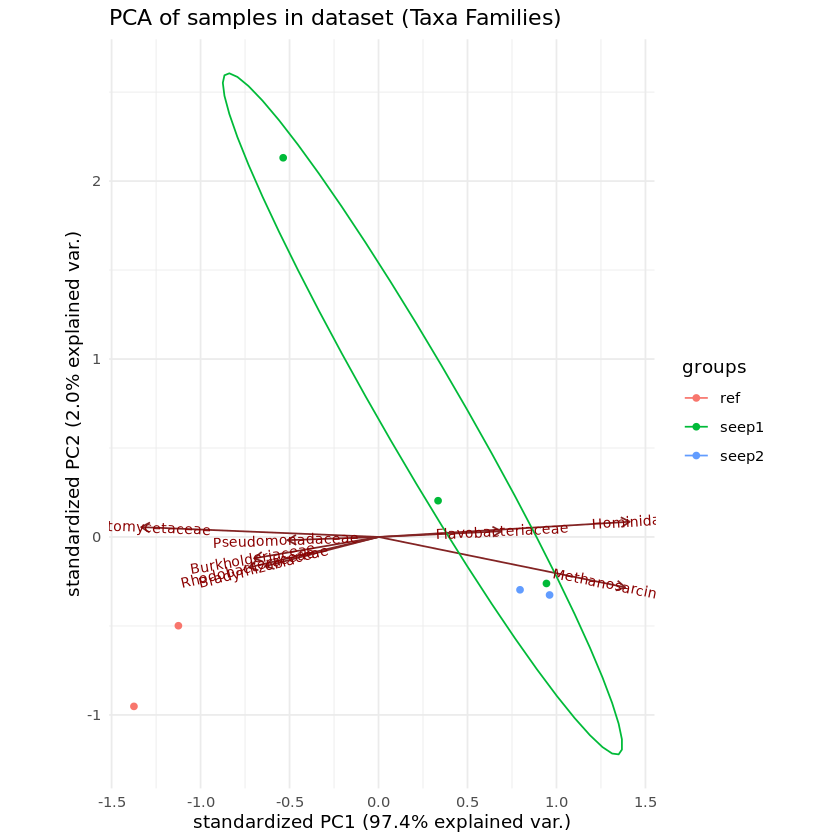

In [8]:
library(devtools)
library(ggbiplot)

#normalizing the data using raremax but slightly differently than done previously
Data_t=as.data.frame(t(Data))

raremax <-min(rowSums(Data_t))
Srare <- rrarefy(Data_t, raremax)
Srare=as.data.frame(Srare)

#step to remove the variables without a lot of variance
#removes columns with sums
Srare_clean = Srare[, colSums(Srare > 40000) > 0]

#computing the principal coordinates
data.pca=prcomp(Srare_clean, center = TRUE)
summary(data.pca)


#PCA plots  
ggbiplot(data.pca)
location=c("seep2","ref","seep1","seep2","seep1","ref","seep1")
ggbiplot(data.pca, varname.size = 3, varname.adjust = .02, ellipse = TRUE, 
         groups = location) +
ggtitle("PCA of samples in dataset (Taxa Families)") +
theme_minimal() +
theme(legend.position = "right")

** Conclusions from this graph **

fill this out after meeting


## non-metric Multidimensionality Scaling (nMDS)

This is another ordination plot that visualizes the data based on the similarity distance from each other. 

** Introduction **

MDS plots maps the position of the samples with n dimensions, by calculating a proximity matrix. The farther the samples are away from each other, the more different they are. 

** Installation ** 
- vegan package (should be already installed if you ran rarefaction curves section)

** Input data ** 

Normalized data. 
In this case it is the the kraken family level abundances that was normalized based on species richness using the rrarefy function 

Run 0 stress 0 
Run 1 stress 9.222167e-05 
... Procrustes: rmse 0.2439839  max resid 0.3495906 
Run 2 stress 9.334988e-05 
... Procrustes: rmse 0.1689525  max resid 0.2215993 
Run 3 stress 6.621907e-05 
... Procrustes: rmse 0.2480201  max resid 0.4136478 
Run 4 stress 9.673096e-05 
... Procrustes: rmse 0.2736968  max resid 0.4830997 
Run 5 stress 0 
... Procrustes: rmse 0.2697082  max resid 0.4795802 
Run 6 stress 9.492452e-05 
... Procrustes: rmse 0.1392906  max resid 0.1804506 
Run 7 stress 9.898332e-05 
... Procrustes: rmse 0.1842327  max resid 0.3309914 
Run 8 stress 9.066999e-05 
... Procrustes: rmse 0.3205297  max resid 0.563579 
Run 9 stress 9.527401e-05 
... Procrustes: rmse 0.3022913  max resid 0.5351862 
Run 10 stress 8.317679e-05 
... Procrustes: rmse 0.2725363  max resid 0.4882472 
Run 11 stress 0 
... Procrustes: rmse 0.1977823  max resid 0.3183992 
Run 12 stress 0 
... Procrustes: rmse 0.2339028  max resid 0.4084156 
Run 13 stress 0 
... Procrustes: rmse 0.1783914  max re

Warning message in metaMDS(d, distance = "bray", k = 3):
“stress is (nearly) zero: you may have insufficient data”


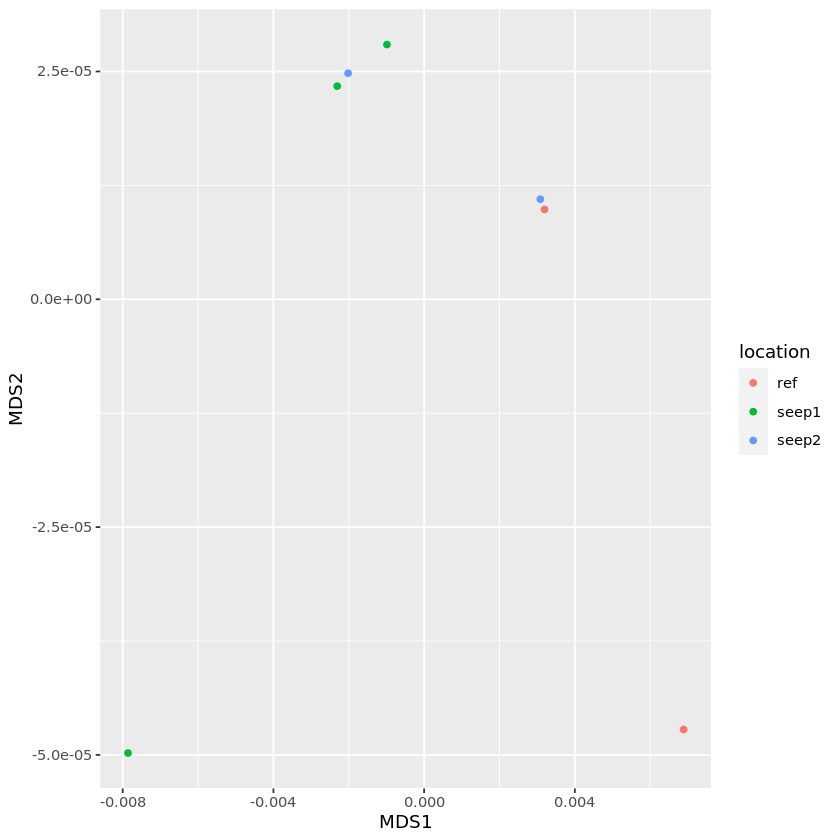

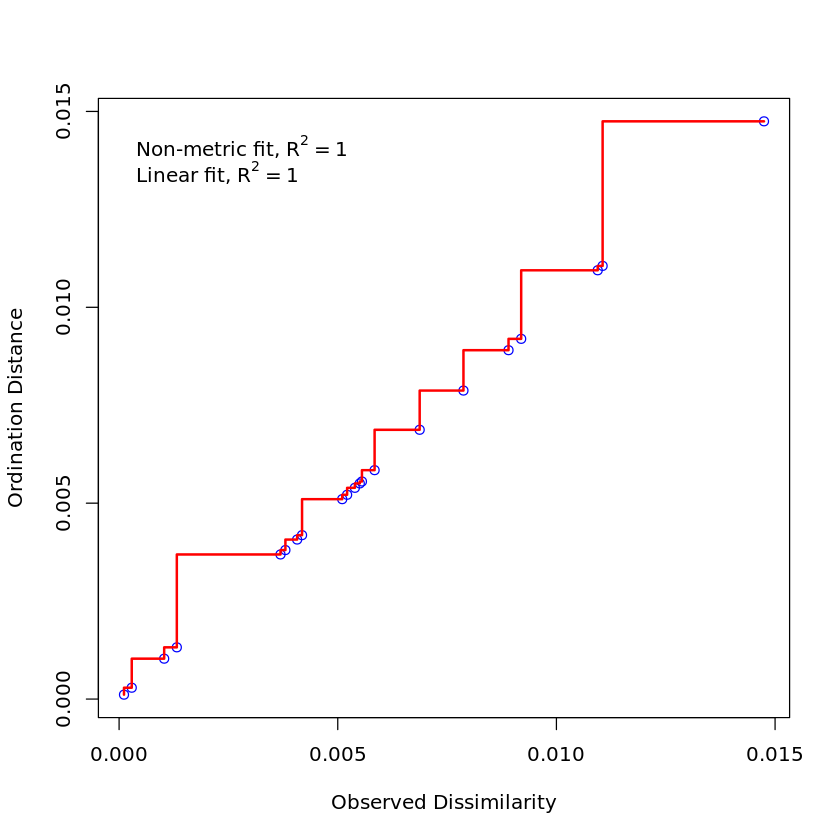

In [28]:
library(vegan)

d=vegdist(Srare, method="bray")
d_matrix=as.matrix(d, labels=T)
mds=metaMDS(d, distance = "bray", k=3) #k=number of dimensions
mds_data=as.data.frame(mds$points)
mds_data$SampleID =rownames(mds_data)

#one way to visaluze the MDS plots 
ggplot(mds_data, aes(x=MDS1, y=MDS2, color= location)) +geom_point()
stressplot(mds)

** Conclusions from the graph **

From this graph we can determine that the two reference samples are very similar to each other as they are placed close to each pther in the graph. Similarly there are more differneces within the seep samples, espcecially the seep1 samples that cluster really far away from each other. In order to further gain more confidence on the representation, we can look at the goodness of fit value that determines the differneces between the actual distances and predicted values. 

The second plot shows the stress value for this data. Ideally, lower stress values indicate greater conformity and therefore are desirable. High stress values indicate that there was no 2-dimensional arrangement of your points that reflect their similarities, which seems to be the case with this data. 

** So this graph or this analysis is inconclusive since the plot does not relect the data correctly ** 

Some of the reasons could be .... ??? need to fill this in!

tried percentages and different distance measures "euclidean" "bray" -- with same results; ask bhavya about reference sample being so close to seeps. guess it doesnt matter if there is no significance anyway

## Prinicpal Coordinate Analysis 

** Introduction **

This is another ordination plot that allows for metric dimensional scaling attempting to represent dimilarity and dissimilarity in a low dimensional space. Unlike PCA, for this analysis the input is the dis-similarity or the similarity matrix as input. 

** Input data ** 

distance matrix from the above MDS calculation from above. 
The beta diversity index is calculated from the input data to calculate the PCoA analysis.


	Homogeneity of multivariate dispersions

Call: betadisper(d = d, group = location)

No. of Positive Eigenvalues: 6
No. of Negative Eigenvalues: 0

Average distance to median:
    ref   seep1   seep2 
0.02590 0.06276 0.01735 

Eigenvalues for PCoA axes:
    PCoA1     PCoA2     PCoA3     PCoA4     PCoA5     PCoA6 
1.128e-01 1.644e-03 6.577e-04 3.352e-04 1.558e-04 3.932e-05 


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,0.002973462,0.001486731,0.9621084,0.4558879
Residuals,4,0.006181138,0.001545285,NA,NA


Warning message in chol.default(cov, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”
Warning message in chol.default(cov, pivot = TRUE):
“the matrix is either rank-deficient or indefinite”


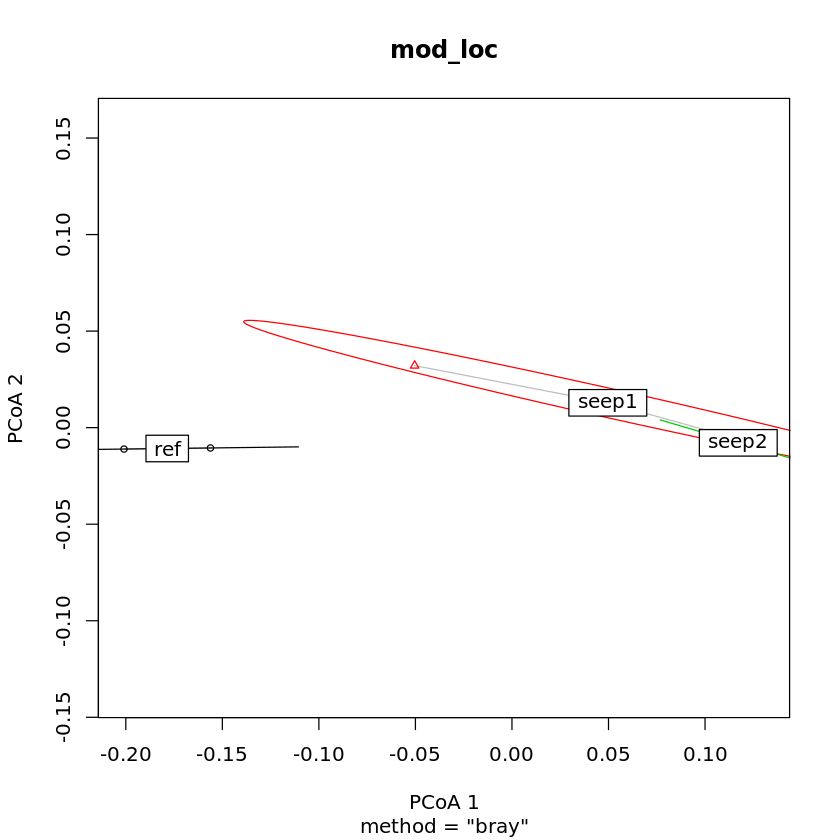

In [12]:
## Beta diversity index and PcoA plots 
## Calculate multivariate dispersions
mod_loc <- betadisper(d, location)

print(mod_loc)
#Statistical test 
anova(mod_loc)


#Plot the groups and distances to centroids on the with data ellipses instead of hulls - PCoA plots 
plot(mod_loc, ellipse = TRUE, hull = FALSE, conf = 0.90) # 90% data ellipse

** Conclusions from the graph **

From this graph we can determine that the two refernece samples are very similar to each other as they are placed close to each other in the graph. Similarly there are more differneces within the seep samples but they cluster together. 

Looking at the statistics, the beta diverity calculated differences are not significant (p>0.05). 

## Alluvial plot

** Introduction **

An alluvial plot is similar to a sankey diagram. Alluvial plots show how sets of groups change according to differnt dimensions. I am making this plot to show how the samples differ between each other. Or to show how each sample changes across the taxa 
families -- i am not sure yet. 

** Installation ** 
- ggaluvial package 
- ggplot2 

** Input data **

The python3 script was ran again on the kraken report directory to get taxa phylums `-r P` and percent of reads covered by taxon `-c 1`. The output of the script was converted to a .csv file as previously using `sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_phylum_percent.csv`. 

The file was reformatted to have every variable in a column. This is necessary for the alluvial plot script. Taxa phylum with low abundance was grouped into one taxa called "Other" and the phylum abundance was binned into three bins. Other variables from the data set were added such as....
The input file for this script is ** phylumreformat.csv **

In [5]:
#Installation of the packages if they aren't already downloaded for alluvial plots 
install.packages("ggalluvial")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,Sample,Taxa,Abundance,AbundanceBin,Location,ThermogenicGases,Hydrocarbons
,<fct>,<fct>,<dbl>,<fct>,<chr>,<chr>,<chr>
1,SRR9649754,Proteobacteria,8.58,"[6,9)",ref,no,no
2,SRR9649754,Actinobacteria,4.04,"[3,6)",ref,no,no
3,SRR9649754,Firmicutes,0.67,"[0,3)",ref,no,no
4,SRR9649754,Planctomycetes,0.80,"[0,3)",ref,no,no
5,SRR9649754,Bacteroidetes,0.39,"[0,3)",ref,no,no
6,SRR9649754,Euryarchaeota,0.25,"[0,3)",ref,no,no


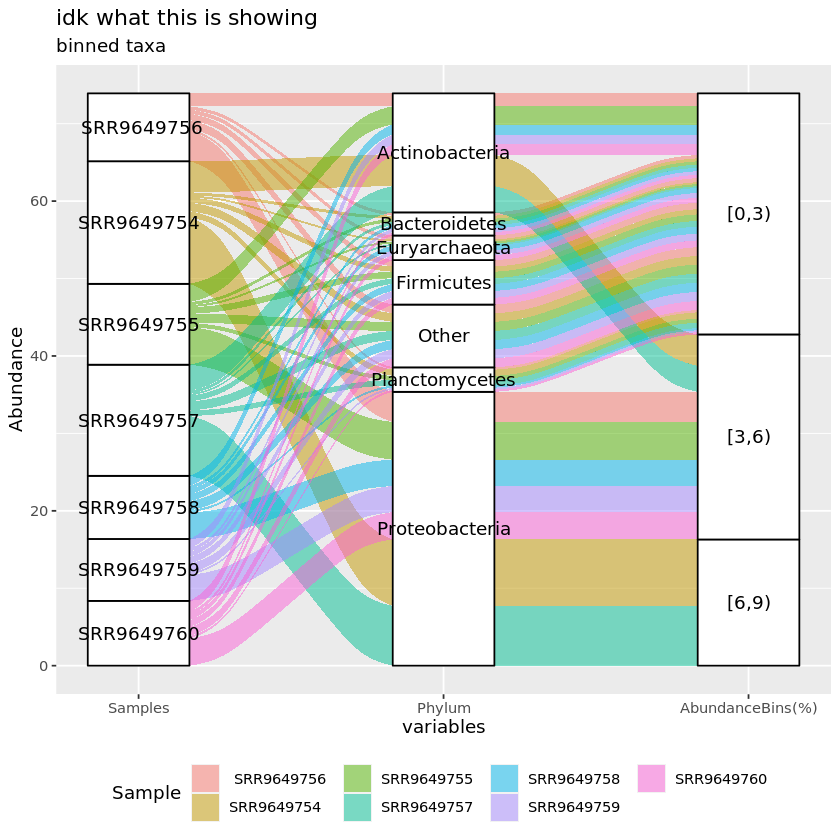

In [29]:
library(ggalluvial);
library(ggplot2);


#reformatted samples and taxa in excel to have abundances in one column to bin 
mydata=read.table("phylumreformat.csv", sep=",", header = TRUE)
#print(data)

#binnning
#not sure about open intervals; right/left=FALSE
mydata$AbundanceBin<-cut(mydata$Abundance, seq(0,9,3), right=FALSE)
#print(data)
reformat=data.frame(mydata)

#add locations/other variables to data
reformat$Location= (c("ref","ref","ref","ref","ref","ref","ref", 
                      "ref","ref","ref","ref","ref","ref","ref", 
                      "transseep1","transseep1","transseep1","transseep1","transseep1","transseep1","transseep1", 
                      "seep1","seep1","seep1","seep1","seep1","seep1","seep1",  
                      "seep1","seep1","seep1","seep1","seep1","seep1","seep1", 
                      "seep2","seep2","seep2","seep2","seep2","seep2","seep2", 
                      "seep2","seep2","seep2","seep2","seep2","seep2","seep2"))
reformat$ThermogenicGases= (c("no","no","no","no","no","no","no",
                              "no","no","no","no","no","no","no",
                              "no","no","no","no","no","no","no",
                              "yes","yes","yes","yes","yes","yes","yes",
                              "yes","yes","yes","yes","yes","yes","yes", 
                              "yes","yes","yes","yes","yes","yes","yes",
                              "yes","yes","yes","yes","yes","yes","yes"))
reformat$Hydrocarbons= (c("no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "no","no","no","no","no","no","no",
                          "yes","yes","yes","yes","yes","yes","yes",
                          "yes","yes","yes","yes","yes","yes","yes"))

head(reformat)

ggplot(data = reformat,
       aes(axis1 = Sample, axis2 = Taxa, axis3 = AbundanceBin,
           y = Abundance)) +
  scale_x_discrete(limits = c("Samples", "Phylum", "AbundanceBins(%)"), expand = c(.11, .05)) +
  xlab("variables") +
  geom_alluvium(aes(fill = Sample)) +
  geom_stratum() + geom_text(stat = "stratum", infer.label = TRUE) +
  theme(legend.position = "bottom") +
  ggtitle("idk what this is showing",
          "binned taxa")

** Conclusions from the graph **

From this graph we can conclude that
